# Binary Text-Sentiment-Analysis using GRU

In [1]:
!pip install comet-ml torchmetrics triton --quiet

## 1. Download and Load the dataset

The command will download combined dataset from `IMDb Movie Dataset` and `YELP Review Dataset`.

In [2]:
!gdown https://drive.google.com/file/d/1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik/view?usp=drive_link --fuzzy
!unzip sentiment_dataset_large.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik
From (redirected): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik&confirm=t&uuid=c91d37c8-a0c3-4dbc-b20e-f007366cd595
To: /content/sentiment_dataset_large.zip
100% 182M/182M [00:01<00:00, 145MB/s]
Archive:  sentiment_dataset_large.zip
replace sentiment_combined.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("sentiment_combined.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610000 entries, 0 to 609999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     610000 non-null  object
 1   sentiment  610000 non-null  object
dtypes: object(2)
memory usage: 9.3+ MB


## 2. Data Analysis

train data shape: (518500,)
test data shape: (91500,)


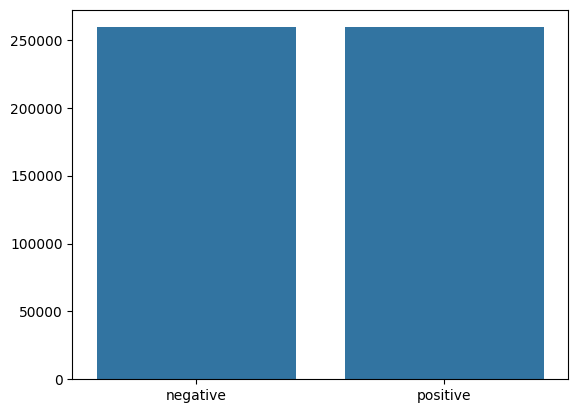

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

X, y = df['review'].values,df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    random_state = 42)
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')


val = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(['negative','positive']),
            y = val.values)
plt.show()

## 3. Text Pre-Processing
- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words") and then lemmatize remaining words for its repsective root words.
- Keeping track of the 1000 most frequently used words in the dataset
- Assigning tracked words a unique identifier, forming dictionary for one-hot encoding
- Ensuring all sequences have the same length by padding or truncating them as needed by 1000+1 tokens. (+1 for padding)

In [6]:
import re
import nltk
from collections import Counter
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Precompile regular expressions for faster preprocessing
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
url_pattern = re.compile(r'http\S+|www\S+')
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")
br_pattern = re.compile(r'<br\s*/?>\s*<br\s*/?>')

# Load stopwords once
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_string(s):
    # Lowercase text
    s = s.lower()
    # Remove URLs
    s = url_pattern.sub('', s)
    # Remove usernames and hashtags
    s = username_pattern.sub('', s)
    s = hashtags_pattern.sub('', s)
    # Remove <br /> HTML tags
    s = br_pattern.sub('', s)
    # Remove non-word characters (preserving letters and numbers only)
    s = non_word_chars_pattern.sub(' ', s)
    # Replace multiple spaces with a single space
    s = whitespace_pattern.sub(' ', s)

    # Tokenize, remove stopwords, and lemmatize
    tokens = s.split()
    filtered_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]
    return ' '.join(filtered_tokens)

In [8]:
def tokenize(X_train, y_train, X_val, y_val, seq_len):
    word_list = []

    for sent in tqdm(X_train, desc="Preprocessing train data"):
        words = [preprocess_string(word) for word in sent.lower().split()]
        word_list.extend([word for word in words if word not in stop_words and word != ''])

    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:seq_len]
    # Creating a dictionary
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # Tokenize and pad sequences
    final_list_train = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                        for sent in tqdm(X_train, desc="Tokenizing and padding train data")]
    final_list_train = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                        for padded_tokens in final_list_train]

    final_list_test = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                       for sent in tqdm(X_val, desc="Tokenizing and padding validation data")]
    final_list_test = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len
                       else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                       for padded_tokens in final_list_test]

    encoded_train = np.array([1 if label == 'positive' else 0 for label in y_train])
    encoded_test = np.array([1 if label == 'positive' else 0 for label in y_val])

    return np.array(final_list_train), encoded_train, np.array(final_list_test), encoded_test, onehot_dict

In [9]:
seq_len = 1000
X_train, y_train, X_test, y_test, vocab = tokenize(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   seq_len)

len(X_train), len(X_test)

Tokenizing and padding validation data: 100%|██████████| 91500/91500 [01:28<00:00, 1038.57it/s]


(518500, 91500)

In [10]:
import pickle

# Save the corpus dictionary
with open("vocab.pkl", 'wb') as f:
    pickle.dump(vocab, f)

In [11]:
X_train, y_train

(array([[  0,   0,   0, ...,  20,  91,   1],
        [  0,   0,   0, ..., 661, 676,  42],
        [  0,   0,   0, ...,  43, 299, 990],
        ...,
        [  0,   0,   0, ...,   3,  95, 629],
        [  0,   0,   0, ..., 216,   3, 309],
        [  0,   0,   0, ...,  19, 106, 105]]),
 array([0, 1, 0, ..., 1, 1, 0]))

## 4. Preparing the data using DataLoader

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [13]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train),
                           torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test),
                           torch.from_numpy(y_test))

BATCH_SIZE = 512

# Create train and valid dataloader
train_dataloader = DataLoader(train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE)

len(train_dataloader), len(valid_dataloader)

(1013, 179)

In [14]:
# Sampling one bacth from train_dataloader
sample_data = iter(train_dataloader)
sample_x, sample_y = next(sample_data)

print('Sample input size:', sample_x.size())     # batch_size, seq_length
print('Sample input:', sample_x)
print('Sample output:', sample_y)

Sample input size: torch.Size([512, 1000])
Sample input: tensor([[  0,   0,   0,  ..., 271, 230,   2],
        [  0,   0,   0,  ...,  30, 205, 888],
        [  0,   0,   0,  ..., 428, 185,   2],
        ...,
        [  0,   0,   0,  ..., 735, 202,  27],
        [  0,   0,   0,  ..., 361, 984,  10],
        [  0,   0,   0,  ..., 464, 750, 833]])
Sample output: tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0

## 5. Building a LSTM Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_dim, key_dim, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.query_layer = nn.Linear(query_dim, hidden_dim)
        self.key_layer = nn.Linear(key_dim, hidden_dim)
        self.energy_layer = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys, values):
        query = self.query_layer(query).unsqueeze(1)
        keys = self.key_layer(keys)

        # Compute energy scores
        energy = torch.tanh(query + keys)
        attention_scores = self.energy_layer(energy).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Compute context vector
        context = torch.bmm(attention_weights.unsqueeze(1), values).squeeze(1)

        return context, attention_weights

In [17]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim=1, num_layers=1, bidirectional=False, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # GRU Layer
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=dropout)

        # Attention
        attention_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.attention = AdditiveAttention(query_dim=attention_dim,
                                           key_dim=attention_dim,
                                           hidden_dim=hidden_dim)

        # Output layer
        self.fc = nn.Linear(attention_dim, output_dim)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # GRU
        x = self.embedding(x)

        gru_out, hn = self.gru(x)   # gru_out: (batch_size, seq_len, hidden_dim * num_directions)

        # Set query as last hidden state of the GRU
        if self.bidirectional:
            # Concatenate the last states of the two directions
            query = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            # Use the last hidden state for unidirectional GRU
            query = hn[-1]

        # Use GRU output as keys and values to compute attention
        context, attention_weights = self.attention(query, gru_out, gru_out)

        # Output layer with sigmoid activation
        out = self.fc(context)
        out = self.sigmoid(out).squeeze(1)

        return out, attention_weights

In [18]:
model = GRUModel(input_dim=len(vocab) + 1,   # 1 extra for padding
                 embedding_dim=64,
                 hidden_dim=256,
                 output_dim=1,
                 num_layers=2,
                 bidirectional=False,         # True for bidirectional LSTM else False for unidirectional LSTM
                 dropout=.2)

# Since dataset is large, it is beneficial to speed up the training process by optimizing the model graph
model = torch.compile(model)
model.to(device)

OptimizedModule(
  (_orig_mod): GRUModel(
    (embedding): Embedding(1001, 64)
    (gru): GRU(64, 256, num_layers=2, batch_first=True, dropout=0.2)
    (attention): AdditiveAttention(
      (query_layer): Linear(in_features=256, out_features=256, bias=True)
      (key_layer): Linear(in_features=256, out_features=256, bias=True)
      (energy_layer): Linear(in_features=256, out_features=1, bias=True)
    )
    (fc): Linear(in_features=256, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

## 6. Create Train and Validation Loop Function

In [19]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="binary").to(device)

In [20]:
def train_step(model, data_loader, loss_fn, optimizer, clip, device, epoch, experiment):
    train_loss, train_acc = 0, 0
    train_losses, train_accuracies = [], []

    model.train()

    for _, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        output, _ = model(inputs)

        loss = loss_fn(output, labels.float())
        train_loss += loss

        preds = torch.round(output.squeeze())
        train_acc += torchmetrics_accuracy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Log metrics to a dictionary
    metrics_dict = {
        "train_loss": train_loss,
        "train_accuracy": train_acc,
    }

    # Log metrics dictionary to Comet ML
    experiment.log_metrics(metrics_dict, step=epoch)

    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc.item())

    return train_losses, train_accuracies


def test_step(model, data_loader, loss_fn, device, epoch, experiment):
    test_loss, test_acc = 0, 0
    test_losses, test_accuracies = [], []
    preds_list, labels_list = [], []

    model.eval()

    with torch.inference_mode():
        for _, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            output, _ = model(inputs)

            loss = loss_fn(output, labels.float())
            test_loss += loss

            preds = torch.round(output.squeeze())
            test_acc += torchmetrics_accuracy(preds, labels)

            # Collect predictions and labels for confusion matrix
            preds_list.extend(preds.cpu().long().numpy())
            labels_list.extend(labels.cpu().long().numpy())

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        # Log metrics to a dictionary
        metrics_dict = {
            "test_loss": test_loss,
            "test_accuracy": test_acc,
        }

        # Log metrics dictionary to Comet ML
        experiment.log_metrics(metrics_dict, step=epoch)

        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc.item())

        return test_losses, test_accuracies, preds_list, labels_list

In [21]:
def train(model, train_dataloader, test_dataloader, classes, loss_fn, optimizer, clip, epochs, device, experiment):
    results = {"train_losses_history": [],
               "train_accuracies_history": [],
               "test_losses_history": [],
               "test_accuracies_history": []

    }
    test_acc_min = 0

    for epoch in tqdm(range(1, epochs+1)):
        train_losses, train_accuracies = train_step(model,
                                                    train_dataloader,
                                                    loss_fn, optimizer, clip,
                                                    device,
                                                    epoch,
                                                    experiment)
        test_losses, test_accuracies, preds_list, labels_list = test_step(model,
                                                                          test_dataloader,
                                                                          loss_fn,
                                                                          device,
                                                                          epoch,
                                                                          experiment)

        # Calculate avg. loss and accuracy
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        avg_test_loss = sum(test_losses) / len(test_losses)
        avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

        print(f'\nTrain loss: {avg_train_loss:.4f} ---- Train acc: {avg_train_accuracy:.4f}')
        print(f'Test loss: {avg_test_loss:.4f} ---- Test acc: {avg_test_accuracy:.4f}\n')

        # Save model if avg_test_accuracy is higher
        if avg_test_accuracy > test_acc_min:
            torch.save(model.state_dict(), 'best_model.pth')
            test_acc_min = avg_test_accuracy
            print(f"Saved best model at epoch: {epoch}\n")

            # Log the confusion matrix to Comet
            experiment.log_confusion_matrix(
                y_true=np.array(labels_list),
                y_predicted=np.array(preds_list),
                labels=classes,
            )

        results["train_losses_history"].append(avg_train_loss)
        results["train_accuracies_history"].append(avg_train_accuracy)
        results["test_losses_history"].append(avg_test_loss)
        results["test_accuracies_history"].append(avg_test_accuracy)

    return results

## 7. Train and Evaluate the Model

In [22]:
# Loss function and Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-4)

In [ ]:
import comet_ml

comet_ml.login(project_name="tweet-sentiment-analysis")
exp = comet_ml.Experiment()

In [26]:
results = train(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = valid_dataloader,
                classes = ["negative", "positive"],
                loss_fn = loss_fn,
                optimizer = optimizer,
                epochs = 10,
                clip = 5,
                device = device,
                experiment = exp)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(



Train loss: 0.3271 ---- Train acc: 0.8484
Test loss: 0.2586 ---- Test acc: 0.8899

Saved best model at epoch: 1



 10%|█         | 1/10 [05:53<53:02, 353.61s/it]


Train loss: 0.2478 ---- Train acc: 0.8950
Test loss: 0.2403 ---- Test acc: 0.8987

Saved best model at epoch: 2



 20%|██        | 2/10 [11:36<46:18, 347.35s/it]


Train loss: 0.2310 ---- Train acc: 0.9024
Test loss: 0.2357 ---- Test acc: 0.8996

Saved best model at epoch: 3



 30%|███       | 3/10 [17:19<40:17, 345.33s/it]


Train loss: 0.2191 ---- Train acc: 0.9078
Test loss: 0.2305 ---- Test acc: 0.9032

Saved best model at epoch: 4



 40%|████      | 4/10 [23:02<34:27, 344.50s/it]


Train loss: 0.2082 ---- Train acc: 0.9127
Test loss: 0.2245 ---- Test acc: 0.9056

Saved best model at epoch: 5



 50%|█████     | 5/10 [28:45<28:40, 344.04s/it]


Train loss: 0.1970 ---- Train acc: 0.9174
Test loss: 0.2212 ---- Test acc: 0.9072

Saved best model at epoch: 6



 60%|██████    | 6/10 [34:28<22:54, 343.68s/it]


Train loss: 0.1857 ---- Train acc: 0.9228
Test loss: 0.2225 ---- Test acc: 0.9079

Saved best model at epoch: 7



 80%|████████  | 8/10 [45:55<11:26, 343.29s/it]


Train loss: 0.1735 ---- Train acc: 0.9283
Test loss: 0.2254 ---- Test acc: 0.9076



 90%|█████████ | 9/10 [51:38<05:43, 343.25s/it]


Train loss: 0.1596 ---- Train acc: 0.9346
Test loss: 0.2328 ---- Test acc: 0.9059



100%|██████████| 10/10 [57:21<00:00, 344.14s/it]


Train loss: 0.1447 ---- Train acc: 0.9411
Test loss: 0.2395 ---- Test acc: 0.9050



In [27]:
exp.log_model(
    name="Binary_Sentiment_GRU_Attention_largerdataset",
    file_or_folder="best_model.pth"
)

exp.log_model(
    name="Vocab",
    file_or_folder="vocab.pkl"
)

exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : intelligent_redshift_6484
COMET INFO:     url                   : https://www.comet.com/luluw8071/tweet-sentiment-analysis/792453c5ff8b47b19878469ccd77d8cb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_accuracy [10]  : (0.8898518085479736, 0.9078647494316101)
COMET INFO:     test_loss [10]      : (0.2212323546409607, 0.25856539607048035)
COMET INFO:     train_accuracy [10] : (0.8484259247779846, 0.9411077499389648)
COMET INFO:     train_loss [10]     : (0.14465101063251495, 0.3270532190799713)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1bxDvWxG54jity7DoNkUfL3x7P1UTEjoj
COMET

## 8. Plot Loss and Accuracy Curves

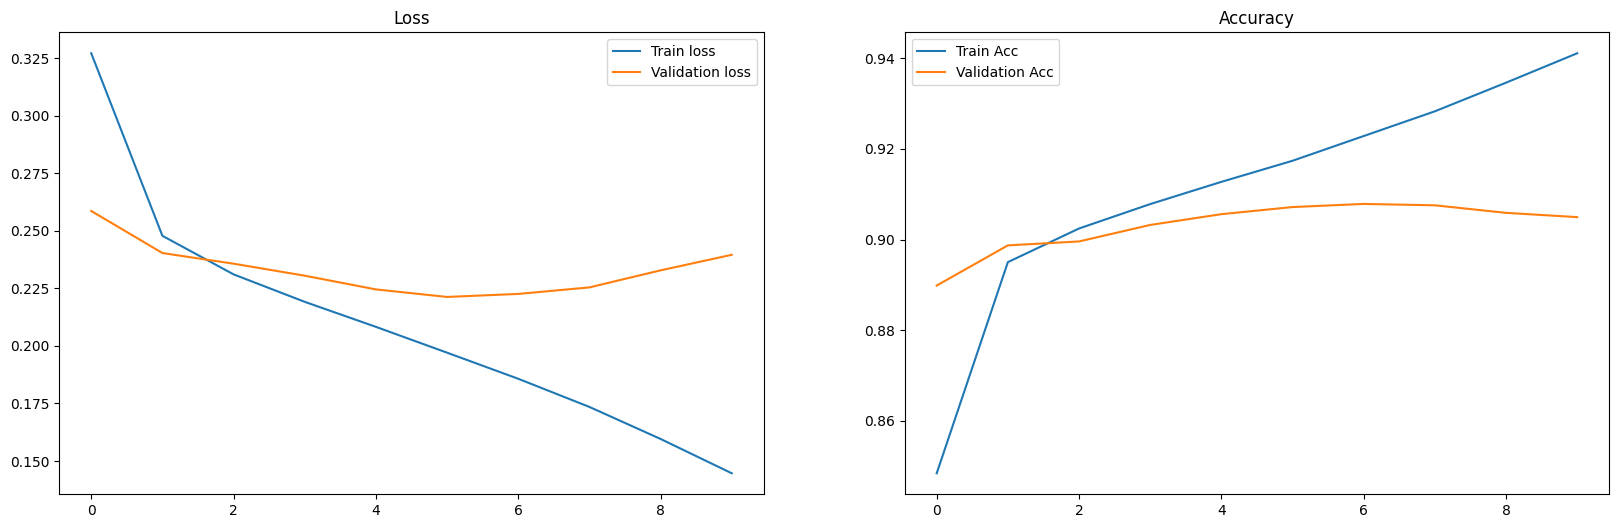

In [28]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(results["train_losses_history"], label='Train loss')
plt.plot(results["test_losses_history"], label='Validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results["train_accuracies_history"], label='Train Acc')
plt.plot(results["test_accuracies_history"], label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

## 9. Load Model to `cpu`

In [29]:
from collections import OrderedDict

# Load model configs
model = GRUModel(input_dim=1001,
                 embedding_dim=64,
                 hidden_dim=256,
                 output_dim=1,
                 num_layers=2,
                 bidirectional=False,
                 dropout=.2)

# Load the model state dict
checkpoint = torch.load("best_model.pth", weights_only=True, map_location="cpu")
model_state_dict = checkpoint.get('state_dict', checkpoint)
new_state_dict = OrderedDict()

for k, v in model_state_dict.items():
    if k.startswith('_orig_mod.'):
        name = k.replace('_orig_mod.', '')
        new_state_dict[name] = v

# Load state dictionaries into the model
model.load_state_dict(new_state_dict, strict=False)
model.eval()

GRUModel(
  (embedding): Embedding(1001, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True, dropout=0.2)
  (attention): AdditiveAttention(
    (query_layer): Linear(in_features=256, out_features=256, bias=True)
    (key_layer): Linear(in_features=256, out_features=256, bias=True)
    (energy_layer): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 10. Make Prediction using Loaded Model

In [30]:
# Load vocab pkl
with open("vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)

In [31]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                      if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq, 1000))
    inputs = pad.to('cpu')
    output, _ = model(inputs)
    return torch.round(output.squeeze()), output.item()

In [32]:
import random

# Randomly select 15 index from dataset to predict
for _ in range(15):
    index = random.randint(0, len(df) - 1)
    review = df['review'][index]
    actual_sentiment = df['sentiment'][index]

    print(review)
    # print(f'Actual sentiment: {actual_sentiment}')

    # Prediction with debug output
    preds, prob = predict_text(review)
    predicted_label_text = "positive" if preds == 1.0 else "negative"
    prob = prob if preds == 1.0 else 1 - prob

    # Color-coding output based on prediction matching actual sentiment
    color = '\033[92m' if actual_sentiment == predicted_label_text else '\033[91m'
    print(f'Predicted sentiment: {color}{predicted_label_text}\033[0m with confidence rate: {prob*100:3f}%')
    print('=' * 70)

MEH!\nSat at the bar because I am traveling alone on bidness. 3 people sitting here with 10 empty chairs and I can't get a water refill.\nStarted with the salmon app, don't bother, I thought it would be chunks of salmon but it was like a chicken salad all mushed together with no flavor. Caesar salad was soggy with no flavor. Needed something healthy like seafood so I ordered the sea bass. Has the cook ever heard of seasoning? It had ZERO flavor on a bed of rice & steamed veggies. I doubt I will come back here. Off to Tim Hortons for anything better.
Predicted sentiment: negative with confidence rate: 99.121476%
Fried chicken like no other. Thin crispy outside and moist inside, a mountain of tater tots, Cole slaw, soft roll and the best hush puppies. That's the dinner or just take home a whole bird to share!
Predicted sentiment: positive with confidence rate: 99.546391%
Had a wonderful experience at dinner last night.  We split the Parma salad.   Perfect with the sliced italian bread!  

In [33]:
def predict_custom_text(custom_text):
    preds, prob = predict_text(custom_text)
    label = "positive" if preds == 1.0 else "negative"
    prob = prob if preds == 1.0 else 1 - prob
    print(f'Predicted: {label} \nProbability {prob*100 :.3f}%')

In [34]:
# Custom Negative Text
custom_text = """
I recently purchased this phone and it has been nothing but a disappointment.
The battery drains incredibly fast, even when it's not in use.
The screen flickers and sometimes goes completely black, forcing me to restart it.
The camera quality is horrible, with blurry photos and grainy videos, even in good lighting.
The device also heats up quickly when using simple apps like the browser or social media.
I contacted customer support, but their response was slow and unhelpful.
It's frustrating to spend so much money on a product that doesn't work as advertised. I would definitely not recommend this phone to anyone.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 90.077%


In [35]:
# Custom Positive Text
custom_text = """
I absolutely love this new laptop! It has exceeded all my expectations in terms of speed and performance. The processor is incredibly fast, and I can switch between multiple applications without any lag. The display is crystal clear, and the colors are vibrant, making it perfect for both work and entertainment. The keyboard feels smooth to type on, and the trackpad is highly responsive.
The battery life is also impressive, lasting a full day with moderate use.
I was a bit hesitant at first, but after using it for a few weeks, I can confidently say it's the best laptop I've owned in years.
Highly recommend!
"""
predict_custom_text(custom_text)

Predicted: positive 
Probability 99.954%


In [36]:
# Custom Positive Text
custom_text = """
I absolutely love this new laptop!
"""
predict_custom_text(custom_text)

Predicted: positive 
Probability 99.772%


### Fail Case Scenario

If text length is too small, it fails to predict the sentiment. This might be due to
- poor quality embeddings and data
- simple sequential model

In [37]:
custom_text = """
I absolutely hated this slow laptop.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 94.959%


In [38]:
custom_text = """
I absolutely hated this slow laptop. Never recommending to buy it.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 95.602%


In [39]:
custom_text = """
I absolutely hated the trash product. NEver buy it. The motherboard has some issues so donot waste money on this product.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 91.845%


In [40]:
# Tryoing out complex sentiments example
custom_text = """
Even though the laptop is slow, I have a lot of emotional attachment to it.
So, I can't just throw away my precious laptop and i love every moment of memories with this laptop.
"""
predict_custom_text(custom_text)

Predicted: positive 
Probability 92.342%
